In [1]:
import numpy as np
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tikzplotlib as tkz
import warnings
warnings.filterwarnings("ignore")

import os, sys
import time
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor, as_completed

_, filename = os.path.split(os.getcwd())
if filename == 'notebooks':
    old_dir = os.getcwd()
    os.chdir('../')
    print('Moving Current Directory from ' + old_dir + ' to ' + os.getcwd())
else:
    print('Current Directory is ' + os.getcwd())

sys.path.append('./')  

from FRB.agents import UCB1Agent, FactoredUCBAgent, MoMRobustUCBAgent
from FRB.env import ParallelFactoredEnv
from FRB.utils import get_pulled_expected, compute_max_expected, create_action_matrix, get_sigma_square_eq_max

Moving Current Directory from /home/simone/Projects/research/FRB/notebooks to /home/simone/Projects/research/FRB


In [2]:
# BASIC SETTING FOR EXPERIMENTS
fucb = '\\JPAalgnameshort'
ucbone = '\\ucbone'
httem = '\\httem'
algs = [fucb, ucbone, httem]

n_trials = 50
k_list = [2] # [int(sys.argv[1])]
d_list = [3] # [int(sys.argv[2])]
T = 10000 # int(sys.argv[3])
out_folder = './results/' # str(sys.argv[4])
ht_mult = 1 # float(sys.argv[5])
sigma = 0.1 # float(sys.argv[6])
parallel_workers = 5

In [3]:
def run_trial_fucb(arg):
    start = time.time()
    agent = arg[0]
    env = arg[1]
    T = arg[2]
    trial = arg[3]

    print('F-UCB: Started run {}.\n'.format(trial), end='')

    vals_expected = list(env.get_expected(trial))
    max_expected = compute_max_expected(vals_expected)
    result = np.zeros(T, dtype=float)

    for i in range(T):
        action = agent.pull_arm()
        agent.update(env.step(trial, action))

        result[i] = max_expected - get_pulled_expected(vals_expected, action)

    end = time.time()
    print('F-UCB: Ended run {}. Elapsed time: {:.2f}s.\n'.format(trial, end-start), end='')
    return result

def run_trial_ucb1(arg):
    start = time.time()
    agent = arg[0]
    action_mx = arg[1]
    env = arg[2]
    T = arg[3]
    trial = arg[4]

    print('UCB-1: Started run {}.\n'.format(trial), end='')

    vals_expected = list(env.get_expected(trial))
    max_expected = compute_max_expected(vals_expected)
    result = np.zeros(T, dtype=float)

    for i in range(T):
        action = action_mx[agent.pull_arm(), :]
        agent.update(np.prod(env.step(trial, action)))

        result[i] = max_expected - get_pulled_expected(vals_expected, action)

    end = time.time()
    print('UCB-1: Ended run {}. Elapsed time: {:.2f}s.\n'.format(trial, end-start), end='')
    return result

def run_trial_ht(arg):
    start = time.time()
    agent = arg[0]
    action_mx = arg[1]
    env = arg[2]
    T = arg[3]
    trial = arg[4]

    print('MoM-HT: Started run {}.\n'.format(trial), end='')

    vals_expected = list(env.get_expected(trial))
    max_expected = compute_max_expected(vals_expected)
    result = np.zeros(T, dtype=float)

    for i in range(T):
        action = action_mx[agent.pull_arm(), :]
        agent.update(env.step(trial, action))

        result[i] = max_expected - get_pulled_expected(vals_expected, action)

    end = time.time()
    print('MoM-HT: Ended run {}. Elapsed time: {:.2f}s.\n'.format(trial, end-start), end = '')
    return result

F-UCB: Started run 0.
F-UCB: Started run 1.
F-UCB: Started run 2.
F-UCB: Started run 3.
F-UCB: Started run 4.
F-UCB: Ended run 4. Elapsed time: 0.80s.
F-UCB: Started run 5.
F-UCB: Ended run 3. Elapsed time: 0.83s.
F-UCB: Started run 6.
F-UCB: Ended run 1. Elapsed time: 0.96s.
F-UCB: Started run 7.
F-UCB: Ended run 2. Elapsed time: 1.19s.
F-UCB: Started run 8.
F-UCB: Ended run 0. Elapsed time: 1.23s.
F-UCB: Started run 9.
F-UCB: Ended run 5. Elapsed time: 0.80s.
F-UCB: Started run 10.
F-UCB: Ended run 6. Elapsed time: 0.99s.
F-UCB: Started run 11.
F-UCB: Ended run 7. Elapsed time: 0.98s.
F-UCB: Started run 12.
F-UCB: Ended run 8. Elapsed time: 1.16s.
F-UCB: Started run 13.
F-UCB: Ended run 9. Elapsed time: 1.20s.
F-UCB: Started run 14.
F-UCB: Ended run 10. Elapsed time: 1.03s.
F-UCB: Started run 15.
F-UCB: Ended run 12. Elapsed time: 0.95s.
F-UCB: Started run 16.
F-UCB: Ended run 11. Elapsed time: 1.09s.
F-UCB: Started run 17.
F-UCB: Ended run 13. Elapsed time: 0.98s.
F-UCB: Started run

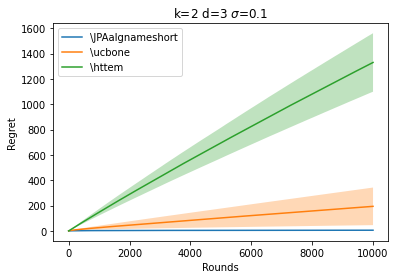

In [4]:
for d in d_list:
    for k in k_list:

        out_path = out_folder + 'out' + str(k) + '_' + str(d) + '.txt'

        env = ParallelFactoredEnv(k, d, n_trials, sigma)
        action_mx = create_action_matrix(d, k)

        # F-UCB
        arms_vect = k * np.ones(d, dtype=int)
        agent = FactoredUCBAgent(arms_vect, d, sigma)

        args = [(deepcopy(agent), deepcopy(env), T, i) for i in range(n_trials)]
        inst_regret_fucb = []

        with ProcessPoolExecutor(max_workers=parallel_workers) as executor:
            for result in executor.map(run_trial_fucb, args):
                inst_regret_fucb.append(result)
            # futures = [executor.submit(run_trial_fucb, arg) for arg in args]
            # inst_regret_fucb = [future.result() for future in as_completed(futures)]

        fucb_regret = np.array(inst_regret_fucb)
        fucb_regret = np.cumsum(fucb_regret, axis=1)

        # UCB1
        agent = UCB1Agent(d*k, sigma)

        args = [(deepcopy(agent), deepcopy(action_mx), deepcopy(env), T, i) for i in range(n_trials)]
        inst_regret_ucb1 = []

        with ProcessPoolExecutor(max_workers=parallel_workers) as executor:
            for result in executor.map(run_trial_ucb1, args):
                inst_regret_ucb1.append(result)
            # futures = [executor.submit(run_trial_ucb1, arg) for arg in args]
            # inst_regret_ucb1 = [future.result() for future in as_completed(futures)]

        ucb1_regret = np.array(inst_regret_ucb1)
        ucb1_regret = np.cumsum(ucb1_regret, axis=1)

        # MoM-HT
        agent = MoMRobustUCBAgent(n_arms=d*k, u=(1+sigma**2)**d-1, mult=ht_mult)
        
        args = [(deepcopy(agent), deepcopy(action_mx), deepcopy(env), T, i) for i in range(n_trials)]
        inst_regret_ht = []

        with ProcessPoolExecutor(max_workers=parallel_workers) as executor:
            for result in executor.map(run_trial_ht, args):
                inst_regret_ht.append(result)
            # futures = [executor.submit(run_trial_ht, arg) for arg in args]
            # inst_regret_ht = [future.result() for future in as_completed(futures)]

        ht_regret = np.array(inst_regret_ht)
        ht_regret = np.cumsum(ht_regret, axis=1)

        plt.figure()
        subsample = 50
        assert T % subsample == 0
        x_plt = np.linspace(0, T-1, int(T/subsample), dtype=int)
        # F-UCB
        plt.plot(x_plt, np.mean(fucb_regret, axis=0)[x_plt], label=fucb)
        plt.fill_between(x_plt,
                         np.mean(fucb_regret, axis=0)[x_plt] - 1.96*np.std(fucb_regret, axis=0)[x_plt]/np.sqrt(n_trials),
                         np.mean(fucb_regret, axis=0)[x_plt] + 1.96*np.std(fucb_regret, axis=0)[x_plt]/np.sqrt(n_trials),
                         alpha=0.3)
        # UCB-1
        plt.plot(x_plt, np.mean(ucb1_regret, axis=0)[x_plt], label=ucbone)
        plt.fill_between(x_plt,
                         np.mean(ucb1_regret, axis=0)[x_plt] - 1.96*np.std(ucb1_regret, axis=0)[x_plt]/np.sqrt(n_trials),
                         np.mean(ucb1_regret, axis=0)[x_plt] + 1.96*np.std(ucb1_regret, axis=0)[x_plt]/np.sqrt(n_trials),
                         alpha=0.3)
        # MoM-HT
        plt.plot(x_plt, np.mean(ht_regret, axis=0)[x_plt], label=httem)
        plt.fill_between(x_plt,
                         np.mean(ht_regret, axis=0)[x_plt] - 1.96*np.std(ht_regret, axis=0)[x_plt]/np.sqrt(n_trials),
                         np.mean(ht_regret, axis=0)[x_plt] + 1.96*np.std(ht_regret, axis=0)[x_plt]/np.sqrt(n_trials),
                         alpha=0.3)

        plt.legend()
        plt.xlabel('Rounds')
        plt.ylabel('Regret')
        plt.title('k={} d={} $\sigma$={}'.format(k, d, sigma))
        save_str = out_folder + 'subgauss_k{}_d{}'.format(k, d)
        plt.savefig(save_str + '.png')
        tkz.save(save_str + '.tex')

